# Introduction

Do higher film budgets lead to more box office revenue? Let's find out if there's a relationship using the movie budgets and financial performance data that I've scraped from [the-numbers.com](https://www.the-numbers.com/movie/budgets) on **May 1st, 2018**. 

<img src=https://i.imgur.com/kq7hrEh.png>

# Import Statements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Notebook Presentation

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Read the Data

In [3]:
data = pd.read_csv('cost_revenue_dirty.csv')

# Explore and Clean the Data

**Challenge**: Answer these questions about the dataset:
1. How many rows and columns does the dataset contain?
2. Are there any NaN values present?
3. Are there any duplicate rows?
4. What are the data types of the columns?

In [4]:
print(data.shape)
print(data.info())

(5391, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Rank                   5391 non-null   int64 
 1   Release_Date           5391 non-null   object
 2   Movie_Title            5391 non-null   object
 3   USD_Production_Budget  5391 non-null   object
 4   USD_Worldwide_Gross    5391 non-null   object
 5   USD_Domestic_Gross     5391 non-null   object
dtypes: int64(1), object(5)
memory usage: 252.8+ KB
None


In [5]:
print(data.sample(10))

      Rank Release_Date            Movie_Title USD_Production_Budget  \
2964  2453    8/31/2007         Death Sentence           $20,000,000   
31    4457   12/24/1943        A Guy Named Joe            $2,627,000   
4508    64    12/7/2013            Pacific Rim          $190,000,000   
1793  2235    3/29/2002             The Rookie           $22,000,000   
4556  3047     2/7/2014          Earth to Echo           $13,000,000   
3653  3546    5/14/2010      Princess Kaiulani            $9,000,000   
490   2791   11/25/1987       3 Men and a Baby           $15,000,000   
1217  2218    3/12/1999  The End of the Affair           $23,000,000   
5304  2277   12/31/2016      The Butterfly God           $22,000,000   
4689  4953    10/1/2014        Banshee Chapter              $950,000   

     USD_Worldwide_Gross USD_Domestic_Gross  
2964         $16,907,831         $9,534,258  
31            $5,363,000         $5,363,000  
4508        $411,002,906       $101,802,906  
1793         $80,491,51

In [6]:
data.isna().values.any()

False

In [7]:
data.duplicated().values.any()

False

### Data Type Conversions

**Challenge**: Convert the `USD_Production_Budget`, `USD_Worldwide_Gross`, and `USD_Domestic_Gross` columns to a numeric format by removing `$` signs and `,`. 
<br>
<br>
Note that *domestic* in this context refers to the United States.

In [8]:
chars_to_remove = [',', '$']
columns_to_clean = ['USD_Production_Budget', 
                    'USD_Worldwide_Gross',
                    'USD_Domestic_Gross']
 
for col in columns_to_clean:
    for char in chars_to_remove:
        # Replace each character with an empty string
        data[col] = data[col].astype(str).str.replace(char, "")
    # Convert column to a numeric data type
    data[col] = pd.to_numeric(data[col])


**Challenge**: Convert the `Release_Date` column to a Pandas Datetime type. 

In [9]:
data['Release_Date'] = pd.to_datetime(data['Release_Date'])

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Rank                   5391 non-null   int64         
 1   Release_Date           5391 non-null   datetime64[ns]
 2   Movie_Title            5391 non-null   object        
 3   USD_Production_Budget  5391 non-null   int64         
 4   USD_Worldwide_Gross    5391 non-null   int64         
 5   USD_Domestic_Gross     5391 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 252.8+ KB


### Descriptive Statistics

**Challenge**: 

1. What is the average production budget of the films in the data set?
2. What is the average worldwide gross revenue of films?
3. What were the minimums for worldwide and domestic revenue?
4. Are the bottom 25% of films actually profitable or do they lose money?
5. What are the highest production budget and highest worldwide gross revenue of any film?
6. How much revenue did the lowest and highest budget films make?

In [11]:
print(data['USD_Production_Budget'].mean())
print(data['USD_Worldwide_Gross'].mean())
print(data['USD_Worldwide_Gross'].min())
print(data['USD_Production_Budget'].max())
print(data.describe())

31113737.57837136
88855421.96271564
0
425000000
          Rank                   Release_Date  USD_Production_Budget  \
count 5,391.00                           5391               5,391.00   
mean  2,696.00  2003-09-19 15:02:02.203672704          31,113,737.58   
min       1.00            1915-08-02 00:00:00               1,100.00   
25%   1,348.50            1999-12-02 12:00:00           5,000,000.00   
50%   2,696.00            2006-06-23 00:00:00          17,000,000.00   
75%   4,043.50            2011-11-23 00:00:00          40,000,000.00   
max   5,391.00            2020-12-31 00:00:00         425,000,000.00   
std   1,556.39                            NaN          40,523,796.88   

       USD_Worldwide_Gross  USD_Domestic_Gross  
count             5,391.00            5,391.00  
mean         88,855,421.96       41,235,519.44  
min                   0.00                0.00  
25%           3,865,206.00        1,330,901.50  
50%          27,450,453.00       17,192,205.00  
75%      

# Investigating the Zero Revenue Films

**Challenge** How many films grossed $0 domestically (i.e., in the United States)? What were the highest budget films that grossed nothing?

In [12]:
no_dom = data[data['USD_Domestic_Gross'] == 0]
print(no_dom.count())
print(no_dom.sort_values('USD_Production_Budget', ascending=False).head(5))

Rank                     512
Release_Date             512
Movie_Title              512
USD_Production_Budget    512
USD_Worldwide_Gross      512
USD_Domestic_Gross       512
dtype: int64
      Rank Release_Date                         Movie_Title  \
5388    96   2020-12-31                         Singularity   
5387   126   2018-12-18                             Aquaman   
5384   321   2018-09-03                   A Wrinkle in Time   
5385   366   2018-10-08                      Amusement Park   
5090   556   2015-12-31  Don Gato, el inicio de la pandilla   

      USD_Production_Budget  USD_Worldwide_Gross  USD_Domestic_Gross  
5388              175000000                    0                   0  
5387              160000000                    0                   0  
5384              103000000                    0                   0  
5385              100000000                    0                   0  
5090               80000000              4547660                   0  


**Challenge**: How many films grossed $0 worldwide? What are the highest budget films that had no revenue internationally?

In [13]:
no_wwgross = data[data['USD_Worldwide_Gross'] == 0]
print(no_wwgross.shape)
print(no_wwgross.sort_values('USD_Production_Budget', ascending=False).head(5))

(357, 6)
      Rank Release_Date        Movie_Title  USD_Production_Budget  \
5388    96   2020-12-31        Singularity              175000000   
5387   126   2018-12-18            Aquaman              160000000   
5384   321   2018-09-03  A Wrinkle in Time              103000000   
5385   366   2018-10-08     Amusement Park              100000000   
5058   880   2015-11-12   The Ridiculous 6               60000000   

      USD_Worldwide_Gross  USD_Domestic_Gross  
5388                    0                   0  
5387                    0                   0  
5384                    0                   0  
5385                    0                   0  
5058                    0                   0  


### Filtering on Multiple Conditions

In [14]:
international_releases = data.loc[(data.USD_Domestic_Gross == 0) &
                                  data.USD_Worldwide_Gross != 0]
international_releases.head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
2309,4623,2004-10-12,Freeze Frame,2000000,105377,0
2579,4531,2005-12-31,Chicken Tikka Masala,2160000,37865,0
2809,3592,2006-11-24,Kurtlar vadisi - Irak,8300000,24906717,0
2889,3666,2007-04-09,The Death and Life of Bobby Z,8000000,414617,0
3049,1927,2007-12-31,Alatriste,28000000,22860477,0


**Challenge**: Use the [`.query()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) to accomplish the same thing. Create a subset for international releases that had some worldwide gross revenue, but made zero revenue in the United States. 

Hint: This time you'll have to use the `and` keyword.

In [15]:
international_releases2 = data.query('USD_Domestic_Gross == 0 and USD_Worldwide_Gross != 0')
international_releases2.tail()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5340,1506,2017-04-14,Queen of the Desert,36000000,1480089,0
5348,2225,2017-05-05,Chāi dàn zhuānjiā,23000000,58807172,0
5360,4832,2017-07-03,Departure,1100000,27561,0
5372,1856,2017-08-25,Ballerina,30000000,48048527,0
5374,4237,2017-08-25,Polina danser sa vie,4000000,36630,0


### Unreleased Films

**Challenge**:
* Identify which films were not released yet as of the time of data collection (May 1st, 2018).
* How many films are included in the dataset that have not yet had a chance to be screened in the box office? 
* Create another DataFrame called data_clean that does not include these films. 

In [16]:
# Date of Data Collection
scrape_date = pd.Timestamp('2018-5-1')

In [17]:
future_releases = data[data.Release_Date >= scrape_date]
future_releases
data_clean = data.drop(future_releases.index)

### Films that Lost Money

**Challenge**: 
What is the percentage of films where the production costs exceeded the worldwide gross revenue? 

In [18]:
# money_losing = data_clean.loc[data_clean.USD_Production_Budget > data_clean.USD_Worldwide_Gross]
# len(money_losing) / len(data_clean)
money_losing = data_clean.query('USD_Production_Budget > USD_Worldwide_Gross')
money_losing.shape[0] / data_clean.shape[0]

0.37277117384843983

# Seaborn for Data Viz: Bubble Charts

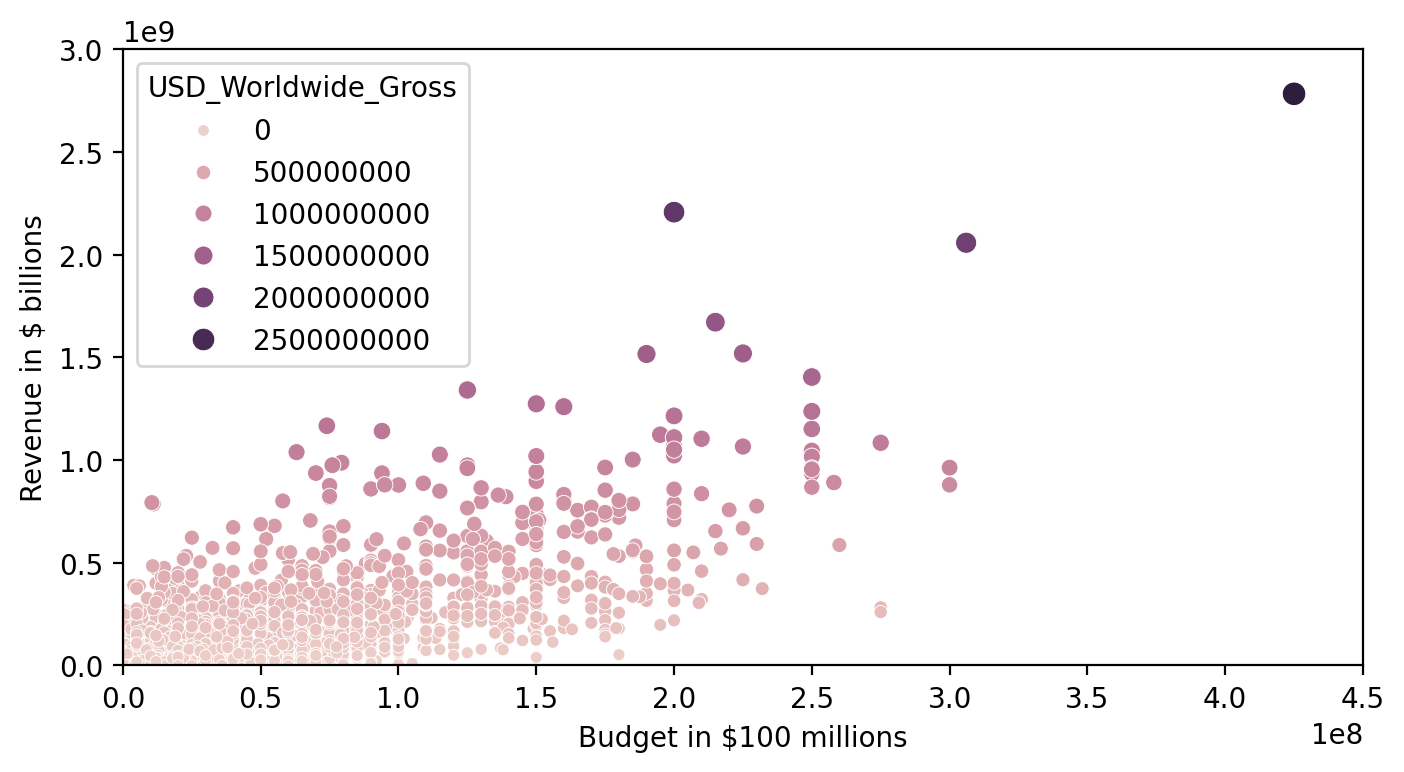

In [19]:
plt.figure(figsize=(8,4), dpi=200)
ax = sns.scatterplot(data=data_clean,
                     x='USD_Production_Budget', 
                     y='USD_Worldwide_Gross',
                     hue='USD_Worldwide_Gross', # colour
                     size='USD_Worldwide_Gross',) # dot size
 
ax.set(ylim=(0, 3000000000),
       xlim=(0, 450000000),
       ylabel='Revenue in $ billions',
       xlabel='Budget in $100 millions',)
 
plt.show()

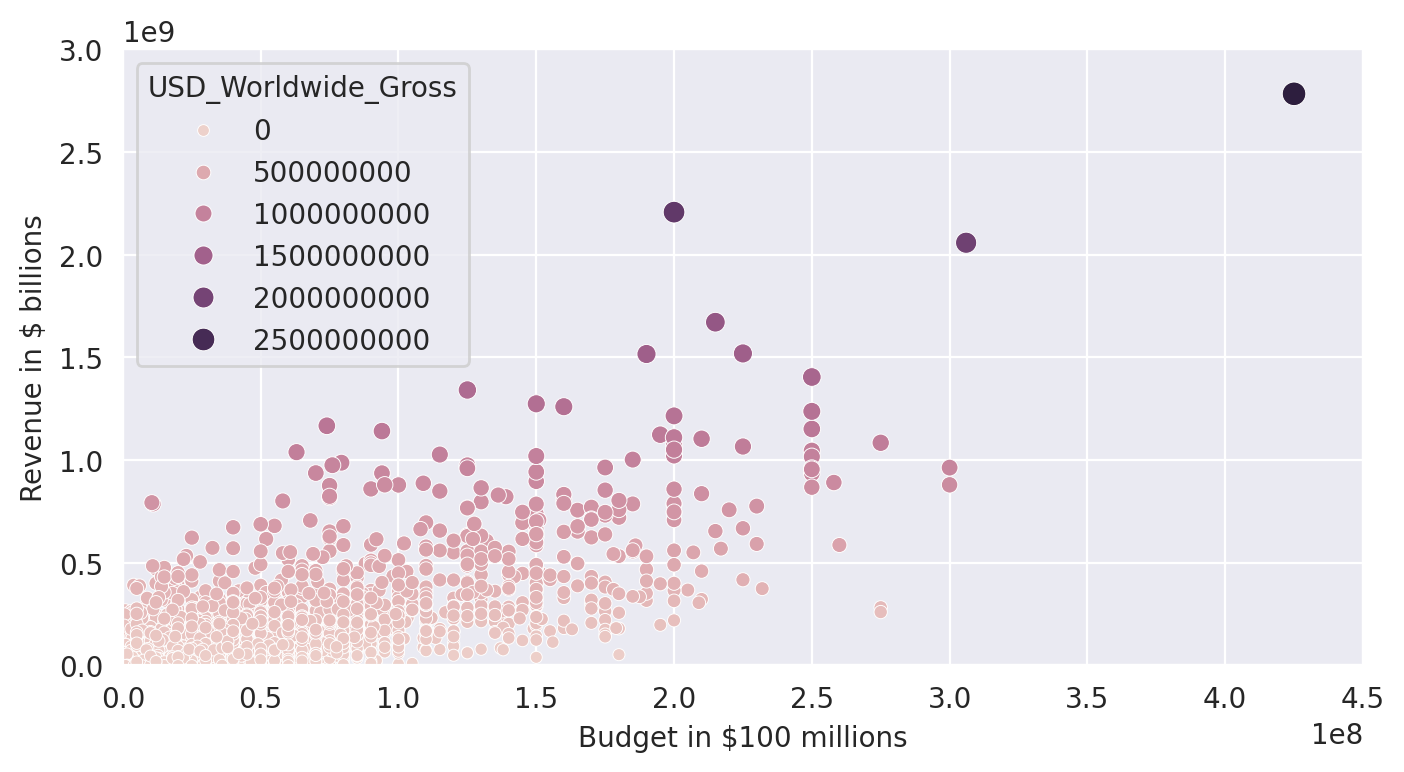

In [20]:
plt.figure(figsize=(8,4), dpi=200)
 
# set styling on a single chart
with sns.axes_style('darkgrid'):
  ax = sns.scatterplot(data=data_clean,
                       x='USD_Production_Budget', 
                       y='USD_Worldwide_Gross',
                       hue='USD_Worldwide_Gross',
                       size='USD_Worldwide_Gross')
 
  ax.set(ylim=(0, 3000000000),
        xlim=(0, 450000000),
        ylabel='Revenue in $ billions',
        xlabel='Budget in $100 millions')

### Plotting Movie Releases over Time

**Challenge**: Try to create the following Bubble Chart:

<img src=https://i.imgur.com/8fUn9T6.png>



In [21]:
data_clean.Release_Date.describe()

count                             5384
mean     2003-09-12 00:26:12.659732480
min                1915-08-02 00:00:00
25%                1999-12-02 00:00:00
50%                2006-06-16 00:00:00
75%                2011-11-18 00:00:00
max                2017-12-31 00:00:00
Name: Release_Date, dtype: object

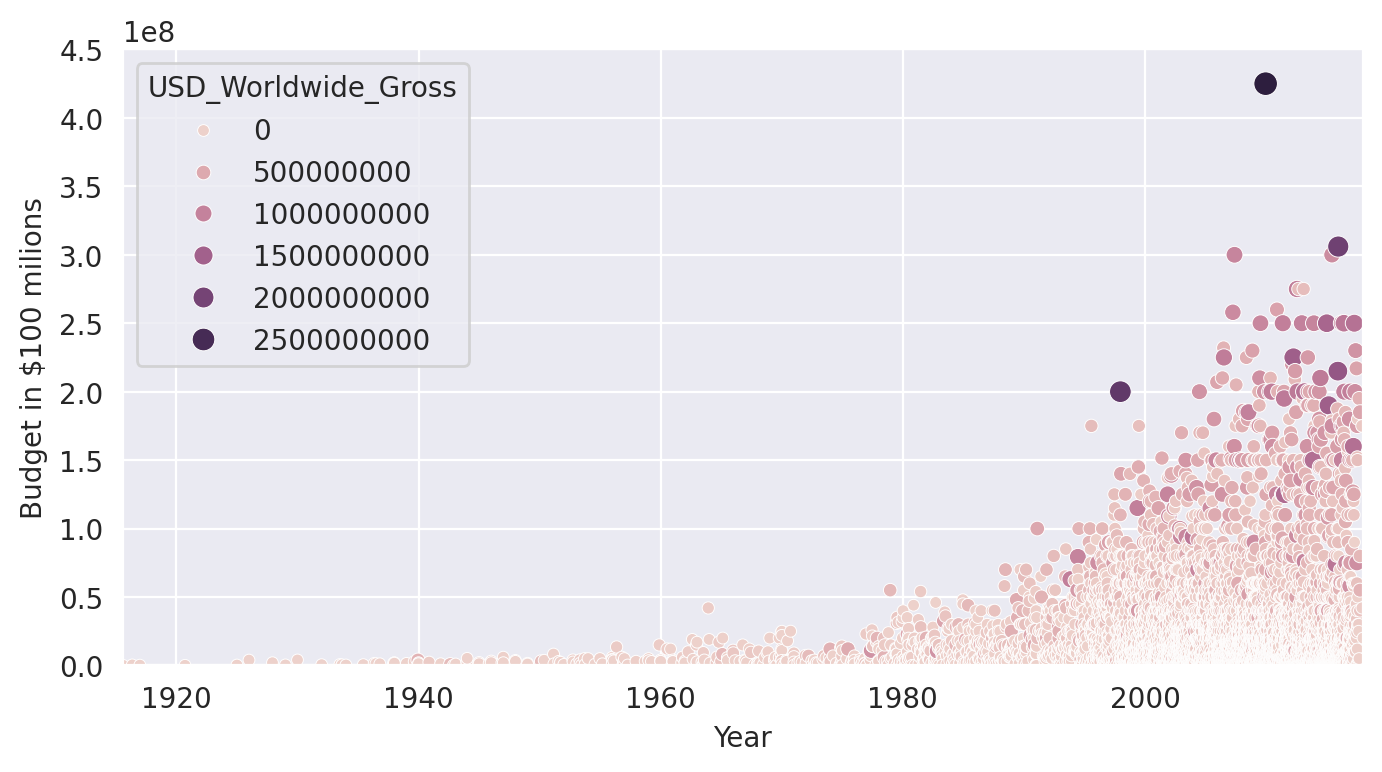

In [22]:
plt.figure(figsize=(8,4), dpi=200)
 
# set styling on a single chart
with sns.axes_style('darkgrid'):
  ax = sns.scatterplot(data=data_clean,
                       x='Release_Date', 
                       y='USD_Production_Budget',
                       hue='USD_Worldwide_Gross',
                       size='USD_Worldwide_Gross')
 
  ax.set(ylim=(0, 450000000),
        xlim=(data_clean.Release_Date.min(), data_clean.Release_Date.max()),
        ylabel='Budget in $100 milions',
        xlabel='Year')

# Converting Years to Decades Trick

**Challenge**: Create a column in `data_clean` that has the decade of the release. 

<img src=https://i.imgur.com/0VEfagw.png width=650> 

Here's how: 
1. Create a [`DatetimeIndex` object](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) from the Release_Date column. 
2. Grab all the years from the `DatetimeIndex` object using the `.year` property.
<img src=https://i.imgur.com/5m06Ach.png width=650>
3. Use floor division `//` to convert the year data to the decades of the films.
4. Add the decades as a `Decade` column to the `data_clean` DataFrame.

In [23]:
data_clean['Decade'] = pd.DatetimeIndex(data_clean['Release_Date']).year

In [24]:
data_clean.Decade = (data_clean.Decade // 10) * 10

In [25]:
data_clean.sample(10)

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Decade
4304,5098,2012-12-31,El rey de Najayo,500000,0,0,2010
3646,718,2010-05-11,Due Date,65000000,211739043,100539043,2010
444,2760,1986-07-03,Highlander,16000000,12900000,5900000,1980
5139,2441,2016-02-09,The Light Between Oceans,20000000,19450780,12545979,2010
703,1972,1993-12-22,Philadelphia,26000000,201324422,77324422,1990
335,2728,1982-08-12,The Verdict,16000000,53977250,53977250,1980
3256,4494,2008-10-31,The Other End of the Line,2500000,507446,115504,2000
2991,3215,2007-09-28,Trade,12000000,1513388,214202,2000
2202,2017,2004-03-26,Scooby-Doo 2: Monsters Unleashed,25000000,181185387,84185387,2000
4254,3963,2012-10-19,Paranormal Activity 4,5000000,140619520,53900335,2010


### Separate the "old" (before 1969) and "New" (1970s onwards) Films

**Challenge**: Create two new DataFrames: `old_films` and `new_films`
* `old_films` should include all the films before 1969 (up to and including 1969)
* `new_films` should include all the films from 1970 onwards
* How many films were released prior to 1970?
* What was the most expensive film made prior to 1970?

In [26]:
old_films = data_clean[data_clean.Decade < 1970]
new_films = data_clean[data_clean.Decade >= 1970]
print(old_films.count())
print(old_films.sort_values('USD_Production_Budget', ascending=False).head(5))

Rank                     153
Release_Date             153
Movie_Title              153
USD_Production_Budget    153
USD_Worldwide_Gross      153
USD_Domestic_Gross       153
Decade                   153
dtype: int64
     Rank Release_Date                   Movie_Title  USD_Production_Budget  \
109  1253   1963-12-06                     Cleopatra               42000000   
150  2175   1969-12-16                  Hello, Dolly               24000000   
143  2465   1969-01-01                 Sweet Charity               20000000   
118  2425   1965-02-15  The Greatest Story Ever Told               20000000   
148  2375   1969-10-15              Paint Your Wagon               20000000   

     USD_Worldwide_Gross  USD_Domestic_Gross  Decade  
109             71000000            57000000    1960  
150             33208099            33208099    1960  
143              8000000             8000000    1960  
118             15473333            15473333    1960  
148             31678778          

# Seaborn Regression Plots

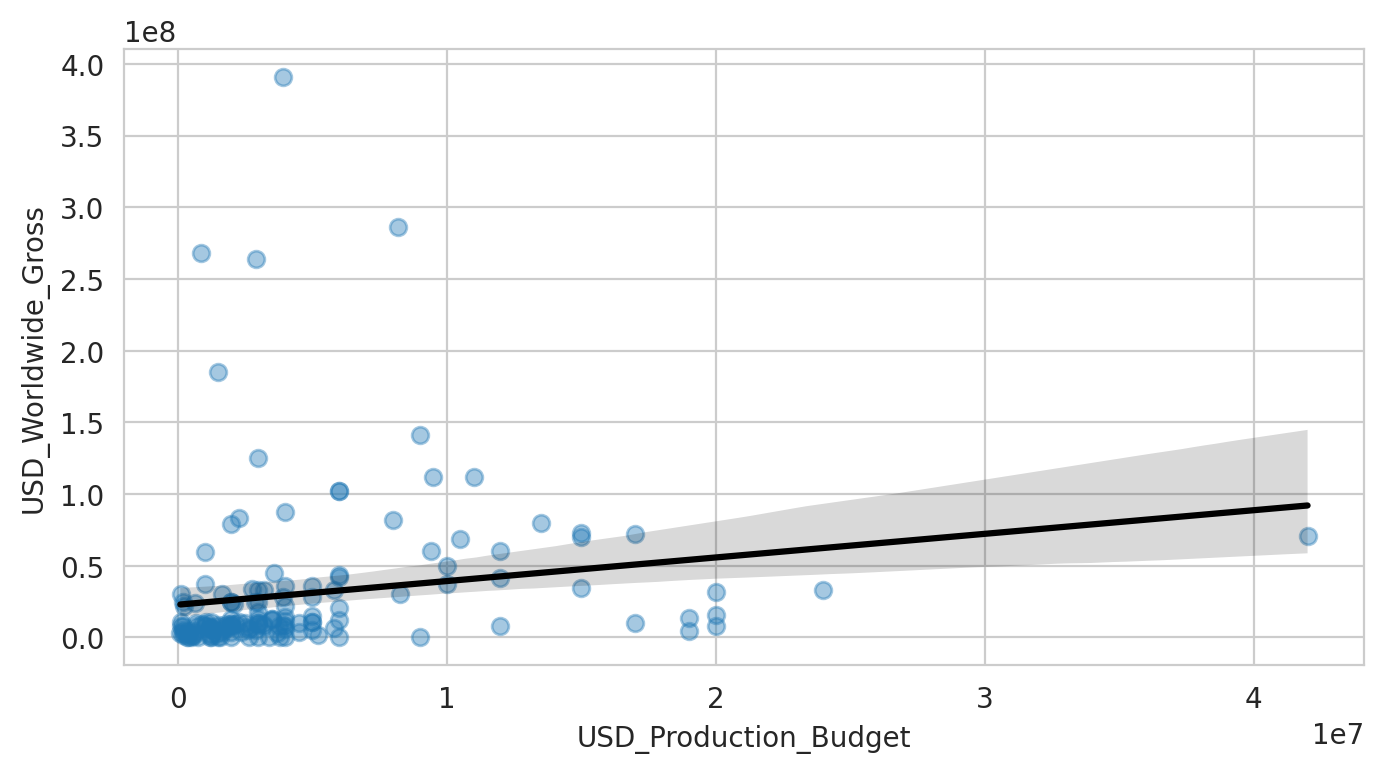

In [27]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style("whitegrid"):
  sns.regplot(data=old_films, 
            x='USD_Production_Budget', 
            y='USD_Worldwide_Gross',
            scatter_kws = {'alpha': 0.4},
            line_kws = {'color': 'black'})

**Challenge**: Use Seaborn's `.regplot()` to show the scatter plot and linear regression line against the `new_films`. 
<br>
<br>
Style the chart

* Put the chart on a `'darkgrid'`.
* Set limits on the axes so that they don't show negative values.
* Label the axes on the plot "Revenue in \$ billions" and "Budget in \$ millions".
* Provide HEX colour codes for the plot and the regression line. Make the dots dark blue (#2f4b7c) and the line orange (#ff7c43).

Interpret the chart

* Do our data points for the new films align better or worse with the linear regression than for our older films?
* Roughly how much would a film with a budget of $150 million make according to the regression line?

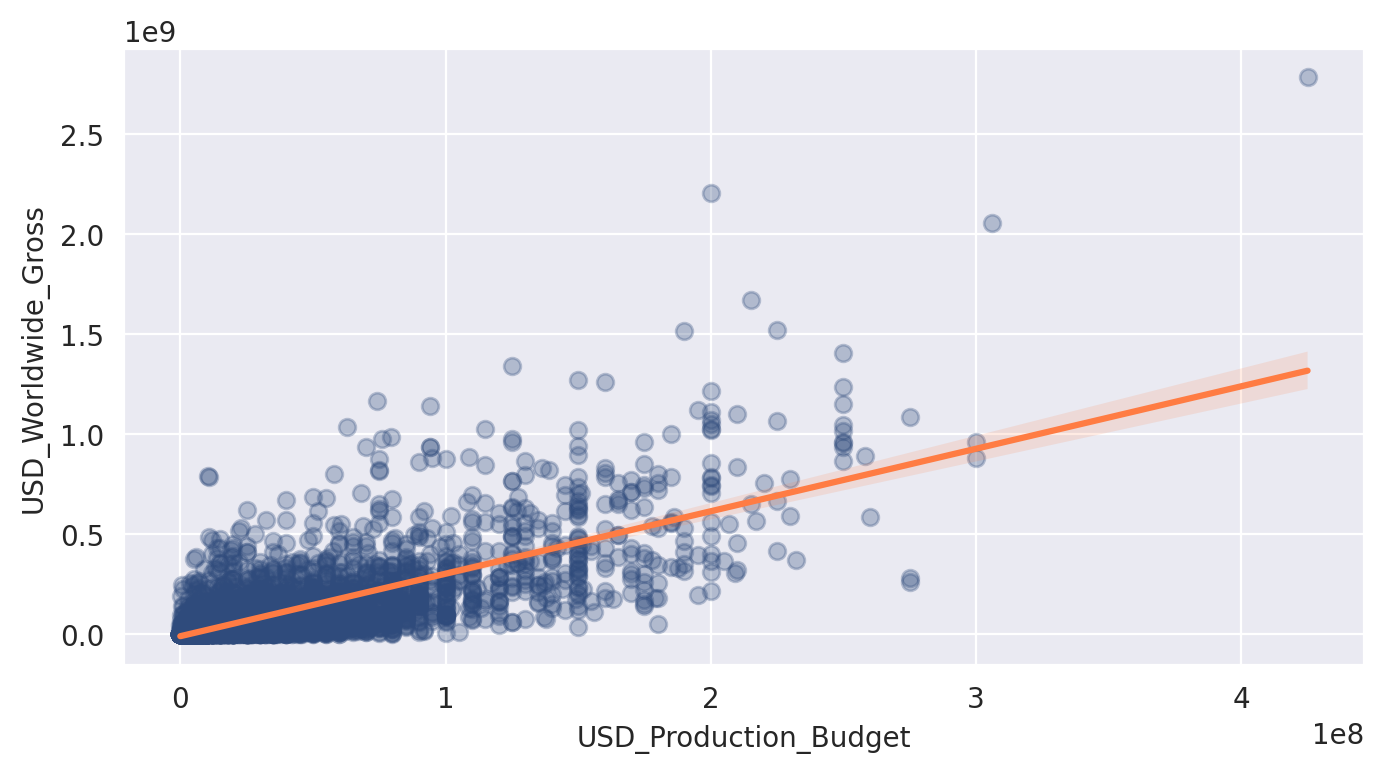

In [28]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style("darkgrid"):
  sns.regplot(data=new_films, 
            x='USD_Production_Budget', 
            y='USD_Worldwide_Gross',
            color='#2f4b7c',
            scatter_kws = {'alpha': 0.3},
            line_kws = {'color': '#ff7c43'})
  ax.set(ylim=(0, new_films['USD_Worldwide_Gross'].max()),
         xlim=(0, new_films['USD_Production_Budget'].max()),
         ylabel= 'Revenue in $ bilions',
         xlabel= 'Budget in 100$ milions')

# Run Your Own Regression with scikit-learn

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

In [32]:
regression = LinearRegression()
# Explanatory Variable(s) or Feature(s)
X = pd.DataFrame(new_films, columns=['USD_Production_Budget'])
 
# Response Variable or Target
y = pd.DataFrame(new_films, columns=['USD_Worldwide_Gross'])

regression.fit(X, y)
print(regression.intercept_)
print(regression.coef_)

# R-squared
regression.score(X, y)

[-8650768.00661042]
[[3.12259592]]


0.5577032617720403

**Challenge**: Run a linear regression for the `old_films`. Calculate the intercept, slope and r-squared. How much of the variance in movie revenue does the linear model explain in this case?

In [33]:
old_regression = LinearRegression()
# Explanatory Variable(s) or Feature(s)
A = pd.DataFrame(old_films, columns=['USD_Production_Budget'])
 
# Response Variable or Target
b = pd.DataFrame(old_films, columns=['USD_Worldwide_Gross'])

old_regression.fit(A, b)
print(old_regression.intercept_)
print(old_regression.coef_)

# R-squared
old_regression.score(A, b)

[22821538.63508039]
[[1.64771314]]


0.02937258620576877

In [34]:
print(-8650768.00661042 + 3.12259592 * 350000000)

1084257803.9933896


# Use Your Model to Make a Prediction

We just estimated the slope and intercept! Remember that our Linear Model has the following form:

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

**Challenge**:  How much global revenue does our model estimate for a film with a budget of $350 million? 

In [35]:
budget = 350000000
revenue_estimate = regression.intercept_[0] + regression.coef_[0,0]*budget
revenue_estimate = round(revenue_estimate, -6)
print(f'The estimated revenue for a $350 film is around ${revenue_estimate:.10}.')

The estimated revenue for a $350 film is around $1.084e+09.
